# Control Environment

Here we can test the components of the MEI generation program.\
We will use as Loss the linear model for predicting the fire rate of simple cell in V1, and use as kernel the Gabor Function.\
As a result we expect the MEI to resemble the Gabor Kernel used in the Loss. 

## Generic Imports and Auxiliary Functions

In [1]:
# Generic Imports
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import ipywidgets as widget
from ipywidgets import interact, interactive, fixed, IntSlider, FloatSlider
import torch.optim as optim
from scipy import ndimage, signal

from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# show figures inline
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
def myimshow(I, type="rel", figsize=(5,5), title=None, **kwargs):
    # utility function to show image
    plt.figure(figsize=figsize);
    if title != None:
        plt.title(title)
    plt.axis('off')
    # plt.imshow(I, cmap="gray", **kwargs)
    vmin, vmax = None, None
    if type == "abs":
        vmin, vmax = 0, 255
    plt.imshow(I, cmap="gray", vmin=vmin, vmax=vmax, aspect='auto', **kwargs)

In [3]:
def rescale_images(images, low=0, high=1, together=True):
    #rescales pixel value in the range [low,high]
    axis = None if together else (1, 2)
    images = images - images.min(axis=axis, keepdims=True)
    images = images / images.max(axis=axis, keepdims=True) * (high - low) + low
    return images

In [4]:
def adjust_contrast(img, contrast=-1, mu=-1, img_min=0, img_max=255, force=True, verbose=False, steps=5000):
    """
    Performs contrast adjustment of the image, being mindful of the image value bounds (e.g. [0, 255]). Given the bounds
    the normal shift and scale will not guarantee that the resulting image still has the desired mean luminance
    and contrast.
    Args:
        img: image to adjsut the contrast
        contrast: desired contrast - this is taken to be the RMS contrast
        mu: desired mean value of the final image
        img_min: the minimum pixel intensity allowed
        img_max: the maximum pixel intensity allowed
        force: if True, iterative approach is taken to produce an image with the desired stats. This will likely cause
        some pixels to saturate in the upper and lower bounds. If False, then image is scaled simply based on ratio of
        current and desired contrast, and then clipped. This likely results in an image that is higher in contrast
        than the original but not quite at the desired contrast and with some pixel information lost due to clipping.
        verbose: If True, prints out progress during iterative adjustment
        steps: If force=True, this sets the number of iterative steps to be used in adjusting the image. The larger the
        value, the closer the final image would approach the desired contrast.

    Returns:
        adjusted_image - a new image adjusted from the original such that the desired mean/contrast is achieved to the
            best of the configuration.
        clipped - Whether any clipping took place. If True, it indicates that some clipping of pixel intensities occured
            and thus some pixel information was lost.
        actual_contrast - the final contrast of the image reached


    """
    current_contrast = img.std()

    if contrast < 0:
        gain = 1   # no adjustment of contrast
    else:
        gain = contrast / current_contrast

    delta = img - img.mean()
    if mu is None or mu < 0: # no adjustment of mean
        mu = img.mean()

    min_pdist = delta[delta > 0].min()
    min_ndist = (-delta[delta < 0]).min()

    # point beyond which scaling would completely saturate out the image (e.g. all pixels would be completely black or
    # white)
    max_lim_gain = max((img_max - mu) / min_pdist, (mu - img_min) / min_ndist)

    vmax = delta.max()
    vmin = delta.min()

    # maximum gain that could be used without losing image information
    max_gain = min((img_max - mu) / vmax, (img_min-mu) / vmin)

    # if True, we already know that the desired contrast cannot be achieved without losing some pixel information
    # into the saturation regime
    clipped = gain > max_gain

    v = np.linspace(0, (img_max-img_min), steps) # candidates for mean adjustment
    if clipped and force:
        if verbose:
            print('Adjusting...')
        cont = []
        imgs = []
        gains = np.logspace(np.log10(gain), np.log10(max_lim_gain), steps)
        # for each gain, perform offset adjustment such that the mean is equal to the set value
        for g in gains:
            img = delta * g + mu
            img = np.clip(img, img_min, img_max)
            offset = img.mean() - mu # shift in clipped image mean caused by the clipping
            if offset < 0: # pixel values needs to be raised
                offset = -offset
                mask = (img_max-img < v[:, None, None])
                nlow = mask.sum(axis=(1, 2)) # pixels that are closer to the bound than v
                nhigh = img.size - nlow
                # calculate the actual shift in mean that can be achieved by shifting all pixels by v
                # then clipping
                va = ((mask * (img_max-img)).sum(axis=(1, 2)) + v * nhigh) / (nlow + nhigh)

                # find the best candidate offset that achieves closest to the desired shift in the mean
                pos = np.argmin(np.abs(va - offset))
                actual_offset = -v[pos]
            else:
                mask = (img-img_min < v[:, None, None])
                nlow = mask.sum(axis=(1, 2))
                nhigh = img.size - nlow
                # actual shift in mean that can be achieved by shifting all pixels by v
                va = ((mask * (img-img_min)).sum(axis=(1, 2)) + v * nhigh) / (nlow + nhigh)
                pos = np.argmin(np.abs(va - offset))
                actual_offset = v[pos]


            img = img - actual_offset
            img = np.clip(img, img_min, img_max)
            # actual contrast achieved with this scale and adjustment
            c = img.std()
            cont.append(c)
            imgs.append(img)
            if c > contrast:
                break
        loc = np.argmin(np.abs(np.array(cont) - contrast))
        adj_img = imgs[loc]
    else:
        adj_img = delta * gain + mu
        adj_img = np.clip(adj_img, img_min, img_max)
    actual_contrast = adj_img.std()
    return adj_img, clipped, actual_contrast

In [5]:
def plot_sample(x_gen_store,n_sample,nrows,save_dir, fn,  w, save=False):
    ncols = max(1,n_sample//nrows)
    sx_gen_store = np.moveaxis(x_gen_store,2,4)                             # change to Numpy image format to (h,w,channels) vs (channels,h,w)
    # nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)   # unity norm to put in range [0,1] for np.imshow
    nsx_gen_store = sx_gen_store
    
    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize = (4*ncols, 4*nrows))
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                if ncols*nrows != 1 and nrows != 1:
                    axs[row, col].clear()
                    axs[row, col].set_xticks([])
                    axs[row, col].set_yticks([])
                    plots.append(axs[row, col].imshow(store[i,(row*ncols)+col], vmax=255, vmin=0, aspect='auto', cmap="gray"))
                elif ncols*nrows != 1 and nrows == 1:
                    axs[col].clear()
                    axs[col].set_xticks([])
                    axs[col].set_yticks([])
                    plots.append(axs[col].imshow(store[i,col], vmax=255, vmin=0, aspect='auto', cmap="gray"))
                else:
                    axs.clear()
                    axs.set_yticks([])
                    axs.set_xticks([])
                    plots.append(axs.imshow(store[i,col], vmax=255, vmin=0, aspect='auto', cmap="gray"))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],  interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0]) 
    plt.close()
    if save:
        ani.save(save_dir + f"{fn}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")
    return ani

In [6]:
def fft_filter(grad):
    return grad

In [7]:
def create_gabor(sz=(90,60), phase=0, wavelength=np.pi, orientation=45.0, sigma=5,
                 dy=0, dx=0):
    """ Create a gabor patch (sinusoidal + gaussian).

    Arguments:
        height (int): Height of the image in pixels.
        width (int): Width of the image in pixels.
        phase (float): Angle at which to start the sinusoid in degrees.
        wavelength (float): Wavelength of the sinusoid (1 / spatial frequency) in pixels.
        orientation (float): Counterclockwise rotation to apply (0 is horizontal) in
            degrees.
        sigma (float): Sigma of the gaussian mask used in pixels
        dy (float): Amount of translation in y (positive moves down) in pixels/height.
        dx (float): Amount of translation in x (positive moves right) in pixels/height.

    Returns:
        Array of height x width shape with the required gabor.
    """
    if isinstance(sz, (int, float)):
        height, width = int(sz), int(sz)
    elif isinstance(sz, tuple) and len(sz) == 2:
        height, width = int(sz[0]), int(sz[1])
    
    # Compute image size to avoid translation or rotation producing black spaces
    padding = max(height, width)
    imheight = height + 2 * padding
    imwidth = width + 2 * padding
    # we could have diff pad sizes per dimension = max(dim_size, sqrt((h/2)^2 + (w/2)^2))
    # but this simplifies the code for just a bit of inefficiency

    # Create sinusoid with right wavelength and phase
    start_sample = phase
    step_size = 360 / wavelength
    samples = start_sample + step_size * np.arange(imheight)
    samples = np.mod(samples, 360)  # in degrees
    rad_samples = samples * (np.pi / 180)  # radians
    sin = np.sin(rad_samples)

    # Create Gabor by stacking the sinusoid along the cols
    gabor = np.tile(sin, (imwidth, 1)).T

    # Rotate around center
    gabor = ndimage.rotate(gabor, orientation, reshape=False)

    # Apply gaussian mask, its is normalized to take values in [0,1]
    gaussy = signal.windows.gaussian(imheight, std=sigma)
    gaussx = signal.windows.gaussian(imwidth, std=sigma)
    mask = np.outer(gaussy, gaussx)
    gabor = gabor * mask

    # Translate (this is only approximate but it should be good enough)
    if abs(dx) > 1 or abs(dy) > 1:
        raise ValueError('Please express translations as factors of the height/width,'
                         'i.e, a number in interval [-1, 1] ')
    dy = int(dy * height)  # int is the approximation
    dx = int(dx * width)
    gabor = gabor[padding - dy: -padding - dy, padding - dx: -padding - dx]

    if gabor.shape != (height, width):
        raise ValueError('Dimensions of gabor do not match desired dimensions.')

    return gabor.astype(np.float32)

In [8]:
def penalty1(image, target=16.0):
    # assert image.min()>=0, "Image needs rescaling"
    # assert image.max()<=255, "image needs rescaling"
    
    # Measure current contrast with RMS
    contrast = image.std()
    penalty = torch.abs(contrast-target)
    return penalty

In [9]:
def Loss_fn1(image, device='cpu', penalty=False, norm=True, lambda_factor=2000, target=16.0, **kwargs):
    # kwargs are passed to create_gabor: phase=0, wavelength=10, orientation=0, sigma=5, dy=0, dx=0

    # Gabor function applied to (x,y) grid centered in (0,0) of size "sz"  /  2D Tensor [sz,sz]
    height, width = image.size()
    D = torch.tensor(create_gabor(sz=(height, width), **kwargs)).to(device)

    # Component-wise multiplication, normalized by number of pixels  /  2D Tensor [sz,sz]
    prod = torch.mul(D,image)
    
    # Compute the sum over both x and y
    result = torch.sum(prod)

    if norm:
        result = result * (1/(height*width))

    if penalty:
        result = result - lambda_factor * penalty1(image, target)

    return result

In [10]:
def GD(sz=3, 
       step=100, n_epoch=200, 
       loss_fn=Loss_fn1, fft_filter=fft_filter,
       smooth_check=False, blurr_check=False, blur=1, 
       penalty=False, lambda_factor=100 , target=16.0, 
       verbose=False, picture=0, 
       **kwargs):
    
    torch.manual_seed(42)

    if isinstance(sz, (int, float)):
        height, width = int(sz), int(sz)
    elif isinstance(sz, tuple) and len(sz) == 2:
        height, width = int(sz[0]), int(sz[1])

    # Select what device we are using
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    print("device: ", device)

    # Initialize the starting point: a (sz,sz) tensor with random integers from 0 to 255 (8 bit grayscale) 
    # converted as float to satisfy backpropagation requirements and moved to device

    image = torch.randint(0, 255, (height,width)).float().to(device)
    controll = image.clone()    # Controll image, we do not apply any denoising

    # Keeps Track of image progress during ascent
    log1 = []   # For image
    log0 = []   # For controll

    # Set requires grad to true
    image.requires_grad_(True)
    

    #----------------
    # Take a look at the random integer we started with
    if verbose:
        if picture == 2:
            myimshow(image.cpu().detach().numpy(), "abs", title="START")
    #^^^^^^^^^^^^^^^^

    # Iterate for n_epoch times the gradient steps
    for epoch in range(n_epoch):
        image.requires_grad_(True)
        controll.requires_grad_(True)

        # Compute loss function of image 
        loss = loss_fn(image=image, device=device, penalty=penalty, lambda_factor=lambda_factor, target=target, **kwargs)
        loss_controll = loss_fn(image=controll, device=device, penalty=penalty, lambda_factor=lambda_factor, target=target, **kwargs)

        sigma = blur + ((0.001 - blur) * epoch) / n_epoch
        step = step + ((2650 - step) * epoch) / n_epoch

        #----------------
        # Checking the loss at each iteration
        if verbose:
            if n_epoch <= 10:
                print('Epoch:', epoch, 'Loss:', loss.item())

            elif n_epoch <= 100:
                if epoch%10 == 0:
                    print('Epoch:', epoch, 'Loss:', loss.item())

            elif n_epoch <= 1000:
                if epoch%100 == 0:
                    print('Epoch:', epoch, 'Loss:', loss.item())

            else:
                if epoch%500 == 0:
                    print('Epoch:', epoch, 'Loss:', loss.item())
        #^^^^^^^^^^^^^^^^

        # Compute gradients
        loss.backward()
        loss_controll.backward()


        # We don't want to include the update in the gradient computation
        with torch.no_grad():

            grad = image.grad
            grad_controll = controll.grad
            
            # Gradient Smoothing using Fast Fourier Filter on frequencies; part of high frequencies denoise
            if smooth_check:
                grad = fft_filter(image.grad)

            # Proceed with the step: adding the gradient to the imag
            image += step * grad
            controll += step * grad_controll

            # Zeroing the grad for next iteration 
            image.grad.zero_()
            controll.grad.zero_()

            # Blurr image if blurr_check; part of high frequencies denoise
            if blurr_check:
                image = torch.tensor(ndimage.gaussian_filter(image.cpu(), sigma, order=0)).to(device)

            # Clamp the obtained image so that pixel saty in the domain [0,255]
            image.clamp_(0,255)
            controll.clamp_(0,255)

            #----------------
            # Store image every n iterations
            if epoch % 10 == 0:
                log1.append(image.unsqueeze(0).unsqueeze(0).detach().cpu().numpy())
                log0.append(controll.unsqueeze(0).unsqueeze(0).detach().cpu().numpy())
            #^^^^^^^^^^^^^^^^


    #----------------
    # we finished GD, let's see the results
    if verbose:
        if picture:
            myimshow(image.cpu().detach().numpy(), "abs", title="END")
        print("Current Contrast: ", round(image.std().item(), 3))
    #^^^^^^^^^^^^^^^^

    #----------------
    # and check our result against the true
    if verbose:
        if picture:
            myimshow(create_gabor(sz=sz,**kwargs), "rel", title="Controll")
        true = rescale_images(create_gabor(sz=sz,**kwargs), 0,255)
        print("Control Contrast: ",round(true.std(), 3))
    #^^^^^^^^^^^^^^^^

    log1 = np.stack(log1)
    log0 = np.stack(log0)
    log = np.concatenate((log1,log0), axis = 1)
    return log

## Gabor Function

In [11]:
def create_gabor(sz=(90,60), phase=0, wavelength=np.pi, orientation=0, sigma=5,
                 dy=0, dx=0):
    """ Create a gabor patch (sinusoidal + gaussian).

    Arguments:
        height (int): Height of the image in pixels.
        width (int): Width of the image in pixels.
        phase (float): Angle at which to start the sinusoid in degrees.
        wavelength (float): Wavelength of the sinusoid (1 / spatial frequency) in pixels.
        orientation (float): Counterclockwise rotation to apply (0 is horizontal) in
            degrees.
        sigma (float): Sigma of the gaussian mask used in pixels
        dy (float): Amount of translation in y (positive moves down) in pixels/height.
        dx (float): Amount of translation in x (positive moves right) in pixels/height.

    Returns:
        Array of height x width shape with the required gabor.
    """
    if isinstance(sz, (int, float)):
        height, width = int(sz), int(sz)
    elif isinstance(sz, tuple) and len(sz) == 2:
        height, width = int(sz[0]), int(sz[1])
    
    # Compute image size to avoid translation or rotation producing black spaces
    padding = max(height, width)
    imheight = height + 2 * padding
    imwidth = width + 2 * padding
    # we could have diff pad sizes per dimension = max(dim_size, sqrt((h/2)^2 + (w/2)^2))
    # but this simplifies the code for just a bit of inefficiency

    # Create sinusoid with right wavelength and phase
    start_sample = phase
    step_size = 360 / wavelength
    samples = start_sample + step_size * np.arange(imheight)
    samples = np.mod(samples, 360)  # in degrees
    rad_samples = samples * (np.pi / 180)  # radians
    sin = np.sin(rad_samples)

    # Create Gabor by stacking the sinusoid along the cols
    gabor = np.tile(sin, (imwidth, 1)).T

    # Rotate around center
    gabor = ndimage.rotate(gabor, orientation, reshape=False)

    # Apply gaussian mask, its is normalized to take values in [0,1]
    gaussy = signal.windows.gaussian(imheight, std=sigma)
    gaussx = signal.windows.gaussian(imwidth, std=sigma)
    mask = np.outer(gaussy, gaussx)
    gabor = gabor * mask

    # Translate (this is only approximate but it should be good enough)
    if abs(dx) > 1 or abs(dy) > 1:
        raise ValueError('Please express translations as factors of the height/width,'
                         'i.e, a number in interval [-1, 1] ')
    dy = int(dy * height)  # int is the approximation
    dx = int(dx * width)
    gabor = gabor[padding - dy: -padding - dy, padding - dx: -padding - dx]

    if gabor.shape != (height, width):
        raise ValueError('Dimensions of gabor do not match desired dimensions.')

    return gabor.astype(np.float32)

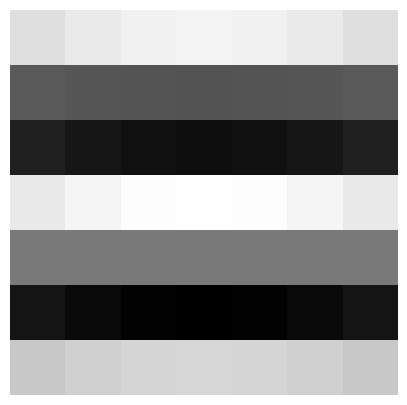

In [12]:
myimshow(create_gabor((7,7)))

## Loss Function

In [13]:
def Loss_fn1(image, device='cpu', penalty=False, norm=True, lambda_factor=2000, target=16.0, **kwargs):
    # kwargs are passed to create_gabor: phase=0, wavelength=10, orientation=0, sigma=5, dy=0, dx=0

    # Gabor function applied to (x,y) grid centered in (0,0) of size "sz"  /  2D Tensor [sz,sz]
    height, width = image.size()
    D = torch.tensor(create_gabor(sz=(height, width), **kwargs)).to(device)

    # Component-wise multiplication, normalized by number of pixels  /  2D Tensor [sz,sz]
    prod = torch.mul(D,image)
    
    # Compute the sum over both x and y
    result = torch.sum(prod)

    if norm:
        result = result * (1/(height*width))

    if penalty:
        result = result - lambda_factor * penalty1(image, target)

    return result

## Gradient Ascent

In [14]:
def GD(sz=7, 
       step=100, n_epoch=500, 
       loss_fn=Loss_fn1, fft_filter=fft_filter,
       smooth_check=False, blurr_check=False, blur=1, 
       penalty=False, lambda_factor=100 , target=16.0, 
       verbose=False, picture=1, 
       **kwargs):
    
    torch.manual_seed(42)

    if isinstance(sz, (int, float)):
        height, width = int(sz), int(sz)
    elif isinstance(sz, tuple) and len(sz) == 2:
        height, width = int(sz[0]), int(sz[1])

    # Select what device we are using
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    print("device: ", device)

    # Initialize the starting point: a (sz,sz) tensor with random integers from 0 to 255 (8 bit grayscale) 
    # converted as float to satisfy backpropagation requirements and moved to device

    image = torch.randint(0, 255, (height,width)).float().to(device)
    controll = image.clone()    # Controll image, we do not apply any denoising

    # Keeps Track of image progress during ascent
    log1 = []   # For image
    log0 = []   # For controll

    # Set requires grad to true
    image.requires_grad_(True)
    

    #----------------
    # Take a look at the random integer we started with
    if verbose:
        if picture == 2:
            myimshow(image.cpu().detach().numpy(), "abs", title="START")
    #^^^^^^^^^^^^^^^^

    # Iterate for n_epoch times the gradient steps
    for epoch in range(n_epoch):
        image.requires_grad_(True)
        controll.requires_grad_(True)

        # Compute loss function of image 
        loss = loss_fn(image=image, device=device, penalty=penalty, lambda_factor=lambda_factor, target=target, **kwargs)
        loss_controll = loss_fn(image=controll, device=device, penalty=penalty, lambda_factor=lambda_factor, target=target, **kwargs)

        sigma = blur + ((0.001 - blur) * epoch) / n_epoch
        step = step + ((2650 - step) * epoch) / n_epoch

        #----------------
        # Checking the loss at each iteration
        if verbose:
            if n_epoch <= 10:
                print('Epoch:', epoch, 'Loss:', loss.item())

            elif n_epoch <= 100:
                if epoch%10 == 0:
                    print('Epoch:', epoch, 'Loss:', loss.item())

            elif n_epoch <= 1000:
                if epoch%100 == 0:
                    print('Epoch:', epoch, 'Loss:', loss.item())

            else:
                if epoch%500 == 0:
                    print('Epoch:', epoch, 'Loss:', loss.item())
        #^^^^^^^^^^^^^^^^

        # Compute gradients
        loss.backward()
        loss_controll.backward()


        # We don't want to include the update in the gradient computation
        with torch.no_grad():

            grad = image.grad
            grad_controll = controll.grad
            
            # Gradient Smoothing using Fast Fourier Filter on frequencies; part of high frequencies denoise
            if smooth_check:
                grad = fft_filter(image.grad)

            # Proceed with the step: adding the gradient to the imag
            image += step * grad
            controll += step * grad_controll

            # Zeroing the grad for next iteration 
            image.grad.zero_()
            controll.grad.zero_()

            # Blurr image if blurr_check; part of high frequencies denoise
            if blurr_check:
                image = torch.tensor(ndimage.gaussian_filter(image.cpu(), sigma, order=0)).to(device)

            # Clamp the obtained image so that pixel saty in the domain [0,255]
            image.clamp_(0,255)
            controll.clamp_(0,255)

            #----------------
            # Store image every n iterations
            if epoch % 10 == 0:
                log1.append(image.unsqueeze(0).unsqueeze(0).detach().cpu().numpy())
                log0.append(controll.unsqueeze(0).unsqueeze(0).detach().cpu().numpy())
            #^^^^^^^^^^^^^^^^


    #----------------
    # we finished GD, let's see the results
    if verbose:
        if picture:
            myimshow(image.cpu().detach().numpy(), "abs")
        print("Current Contrast: ", round(image.std().item(), 3))
    #^^^^^^^^^^^^^^^^

    #----------------
    # and check our result against the true
    if verbose:
        if picture:
            myimshow(create_gabor(sz=sz,**kwargs), "rel")
        true = rescale_images(create_gabor(sz=sz,**kwargs), 0,255)
        print("Control Contrast: ",round(true.std(), 3))
    #^^^^^^^^^^^^^^^^

    log1 = np.stack(log1)
    log0 = np.stack(log0)
    log = np.concatenate((log1,log0), axis = 1)
    return log

## Contrast Adjustment

The first problem encountered is the outpu's pixels diverging to black or white.   
Losing the gray gradient in between the black and white pixels implies loss of information about the intensity of the signal.

### Divergence of output

device:  cuda
Epoch: 0 Loss: 0.21190346777439117
Epoch: 100 Loss: 79.9749984741211
Epoch: 200 Loss: 80.02503204345703
Epoch: 300 Loss: 80.07059478759766
Epoch: 400 Loss: 80.10469818115234
Epoch: 500 Loss: 80.12883758544922
Current Contrast:  127.5
Control Contrast:  91.362


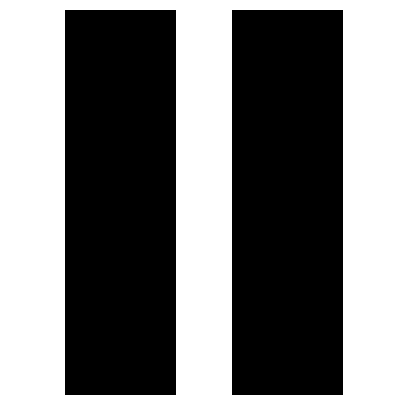

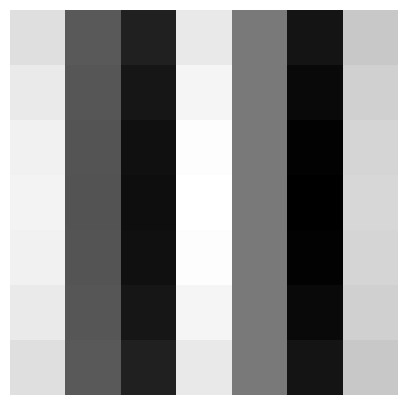

In [15]:
log = GD(sz=7, n_epoch=600, verbose=True, orientation=90.0)

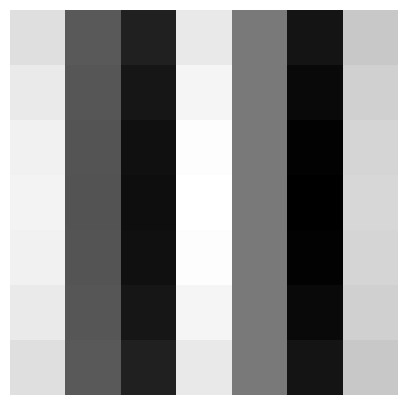

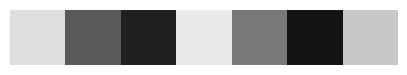

In [16]:
torch.manual_seed(42)
gabor = create_gabor(7,orientation=90.0)
myimshow(gabor)

plt.figure(figsize=(5,1))
plt.axis('off')
plt.imshow([gabor[0]], cmap="gray", vmin=gabor.min(), vmax=gabor.max());

In [17]:
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

(-0.5, 6.5, 5.5, -0.5)

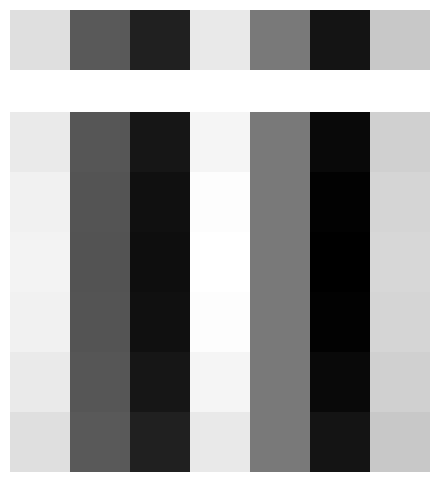

In [18]:
plt.figure(figsize=(6, 6))
gs1 = GridSpec(2, 1, height_ratios=[1, 6])

ax01 = plt.subplot(gs1[0])
ax01.imshow([gabor[0]], cmap="gray", vmin=gabor.min(), vmax=gabor.max())
ax01.axis("off")


ax02 = plt.subplot(gs1[1])
ax02.imshow(gabor[1:], cmap="gray", vmin=gabor.min(), vmax=gabor.max())
ax02.axis("off")

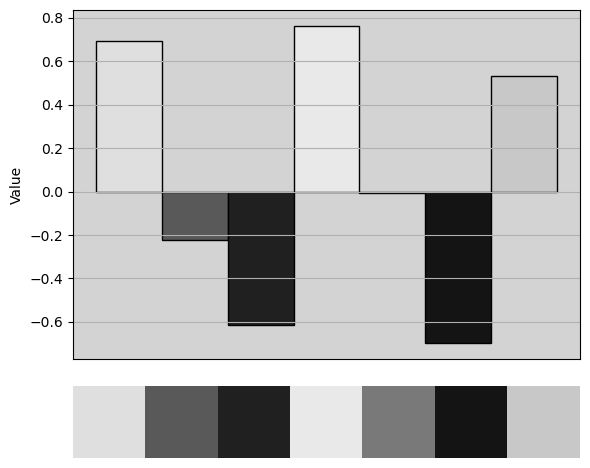

In [19]:
x = np.arange(1, len(gabor[0]) + 1)

norm = mcolors.Normalize(vmin=gabor.min(), vmax=gabor.max())

# Colormap to emulate grayscale
cmap_gray = plt.cm.gray

# Convert data to grayscale colors
colors = [cmap_gray(norm(value)) for value in gabor[0]]

plt.rcParams['axes.facecolor'] = 'lightgray'

# Plot the histogram
plt.figure(figsize=(6, 5))
gs2 = GridSpec(2, 1, height_ratios=[3, 1])

# plt.bar(x, gabor[0], align='center', width=1, color=colors, edgecolor='black')  # Adjust width as needed
# plt.xlabel('Pixel')
# plt.ylabel('Value')
# plt.title('First Row of Pixels')
# plt.grid(True)
# plt.show()

# Plot the histogram in the first row
ax0 = plt.subplot(gs2[0])
ax0.bar(x, gabor[0], align='center', width=1, color=colors, edgecolor='black')
ax0.xaxis.set_visible(False)
ax0.set_ylabel('Value')
# ax0.set_title('Gabor First Pixel Row')
ax0.grid(True)

# Plot the image in the second row
ax1 = plt.subplot(gs2[1])
ax1.imshow([gabor[0]], cmap="gray", vmin=gabor.min(), vmax=gabor.max())
ax1.axis('off')  # Turn off axes for the image plot

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

### Defining Contrast

I'll define contrast as the standard deviation of pixels in the image and introduce a penalty assure it stays close to a target value

### Penalty Function

In [20]:
def penalty1(image, target=16.0):
    assert image.min()>=0, "Image needs rescaling"
    assert image.max()<=255, "image needs rescaling"
    
    # Measure current contrast with RMS
    contrast = image.std()
    penalty = torch.abs(contrast-target)
    return penalty

### Comparison

device:  cuda
Epoch: 0 Loss: -59.95146179199219
Epoch: 100 Loss: -0.7009084820747375
Epoch: 200 Loss: 0.043682560324668884
Epoch: 300 Loss: -0.2969200611114502
Epoch: 400 Loss: 0.4309875965118408
Epoch: 500 Loss: 0.47876882553100586
Epoch: 600 Loss: 0.8951982259750366
Current Contrast:  12.815
Control Contrast:  17.828


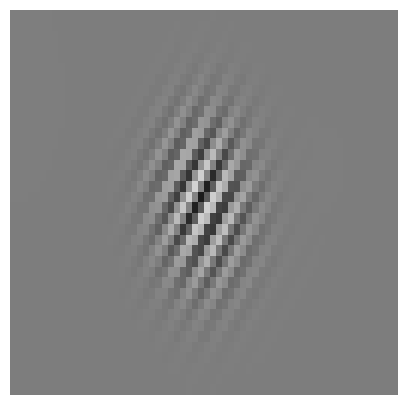

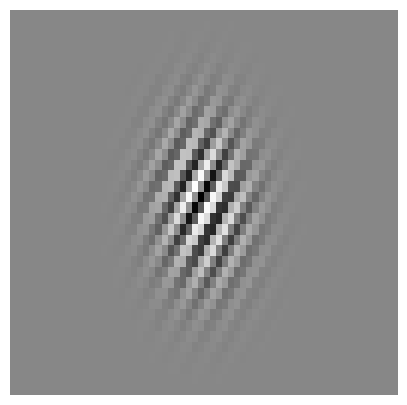

In [74]:
log = GD(sz=(36,64), 
        step=100, n_epoch=700, 
        loss_fn=Loss_fn1, fft_filter=fft_filter,
        smooth_check=False, blurr_check=True, blur=0.5, 
        penalty=True, lambda_factor=1 , target=13.0, 
        verbose=True, picture=1, 
        orientation=45, phase=0, wavelength=np.pi, sigma=5, dy=0.0, dx=0.0)